<a href="https://colab.research.google.com/github/Zahid8/AMU_battlegrounds/blob/main/Brain_Tumor_Classification_(MRI).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install --upgrade -q kaggle

!mkdir /root/.kaggle
import json
token = {
    "username": "username",
    "key": "API KEY"
}

with open('/root/.kaggle/kaggle.json', 'w') as config_file:
    json.dump(token, config_file)
!chmod 600 /root/.kaggle/kaggle.json

!kaggle datasets download -d sartajbhuvaji/brain-tumor-classification-mri

 93% 81.0M/86.8M [00:00<00:00, 63.3MB/s]
100% 86.8M/86.8M [00:01<00:00, 89.2MB/s]


In [ ]:
import zipfile
zipref=zipfile.ZipFile("/content/brain-tumor-classification-mri.zip",'r')
zipref.extractall()
zipref.close()

In [ ]:
import os
num_class=len(os.listdir("/content/Training"))
num_class

4

In [ ]:
train_dir="/content/Training/"
test_dir="/content/Testing/"

In [ ]:
import pathlib
import numpy as np
data_dir = pathlib.Path("/content/Training/") 
class_names = np.array(sorted([item.name for item in data_dir.glob('*')]))
print(class_names) 

['glioma_tumor' 'meningioma_tumor' 'no_tumor' 'pituitary_tumor']


In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen=ImageDataGenerator(rescale=1/255.)
test_datagen=ImageDataGenerator(rescale=1/255.)

train_data = train_datagen.flow_from_directory(train_dir,batch_size=32,
                                               class_mode='categorical',
                                               target_size=(180,180))

test_data = test_datagen.flow_from_directory(test_dir,batch_size=32,
                                               class_mode='categorical',
                                               target_size=(180,180))

Found 2870 images belonging to 4 classes.
Found 394 images belonging to 4 classes.


In [ ]:
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras.models import Sequential
# Setup base model and freeze its layers (this will extract features)
base_model = tf.keras.applications.ResNet50V2(include_top=False)
base_model.trainable = False

# Setup model architecture with trainable top layers
inputs = layers.Input(shape=(180, 180, 3), name="input_layer") # shape of input image
x = base_model(inputs) # put the base model in inference mode so we can use it to extract features without updating the weights
x = layers.GlobalAveragePooling2D(name="global_average_pooling")(x) # pool the outputs of the base model
outputs = layers.Dense(4, activation="softmax", name="output_layer")(x) # same number of outputs as classes
resnet_model = tf.keras.Model(inputs, outputs)

# Compile
resnet_model.compile(loss="categorical_crossentropy",
              optimizer=tf.keras.optimizers.Adam(), # use Adam with default settings
              metrics=["accuracy"])

# Fit
resnet_history = resnet_model.fit(train_data,
                                           epochs=25, # fit for 5 epochs to keep experiments quick
                                           validation_data=test_data,
                                           validation_steps=int(0.15 * len(test_data)), # evaluate on smaller portion of test data
                                           callbacks = [tf.keras.callbacks.ModelCheckpoint("resnet_model.h5",monitor='val_accuracy' ,save_best_only=True, verbose = 1)]) # save best model weights to file

Epoch 1/25
90/90 [==============================] - 17s 156ms/step - loss: 0.8154 - accuracy: 0.6829 - val_loss: 0.9678 - val_accuracy: 0.6875

Epoch 00001: val_accuracy improved from -inf to 0.68750, saving model to resnet_model.h5


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 2/25
90/90 [==============================] - 13s 146ms/step - loss: 0.4551 - accuracy: 0.8338 - val_loss: 0.8778 - val_accuracy: 0.6562

Epoch 00002: val_accuracy did not improve from 0.68750
Epoch 3/25
90/90 [==============================] - 13s 139ms/step - loss: 0.3595 - accuracy: 0.8718 - val_loss: 1.0413 - val_accuracy: 0.6250

Epoch 00003: val_accuracy did not improve from 0.68750
Epoch 4/25
90/90 [==============================] - 13s 139ms/step - loss: 0.3084 - accuracy: 0.8944 - val_loss: 1.3190 - val_accuracy: 0.5938

Epoch 00004: val_accuracy did not improve from 0.68750
Epoch 5/25
90/90 [==============================] - 12s 137ms/step - loss: 0.2733 - accuracy: 0.9045 - val_loss: 0.9743 - val_accuracy: 0.7500

Epoch 00005: val_accuracy improved from 0.68750 to 0.75000, saving model to resnet_model.h5
Epoch 6/25
90/90 [==============================] - 13s 144ms/step - loss: 0.2376 - accuracy: 0.9251 - val_loss: 0.6214 - val_accuracy: 0.9062

Epoch 00006: val_accura

In [ ]:
# Import the required modules for model creation
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras.models import Sequential

# Setup data augmentation
data_augmentation = Sequential([
  preprocessing.RandomFlip("horizontal"), # randomly flip images on horizontal edge
  preprocessing.RandomRotation(0.2), # randomly rotate images by a specific amount
  preprocessing.RandomHeight(0.2), # randomly adjust the height of an image by a specific amount
  preprocessing.RandomWidth(0.2), # randomly adjust the width of an image by a specific amount
  preprocessing.RandomZoom(0.2), # randomly zoom into an image
  # preprocessing.Rescaling(1./255) # keep for models like ResNet50V2, remove for EfficientNet
], name="data_augmentation")

In [ ]:
# Setup base model and freeze its layers (this will extract features)
base_model = tf.keras.applications.ResNet50V2(include_top=False)
base_model.trainable = False

# Setup model architecture with trainable top layers
inputs = layers.Input(shape=(180, 180, 3), name="input_layer") # shape of input image
x = data_augmentation(inputs) # augment images (only happens during training)
x = base_model(x, training=False) # put the base model in inference mode so we can use it to extract features without updating the weights
x = layers.GlobalAveragePooling2D(name="global_average_pooling")(x) # pool the outputs of the base model
outputs = layers.Dense(4, activation="softmax", name="output_layer")(x) # same number of outputs as classes
aug_resnet_model = tf.keras.Model(inputs, outputs)

# Compile
aug_resnet_model.compile(loss="categorical_crossentropy",
              optimizer=tf.keras.optimizers.Adam(), # use Adam with default settings
              metrics=["accuracy"])

# Fit
aug_resnet_history = aug_resnet_model.fit(train_data,
                                           epochs=25, # fit for 5 epochs to keep experiments quick
                                           validation_data=test_data,
                                           validation_steps=int(0.15 * len(test_data)), # evaluate on smaller portion of test data
                                           callbacks = [tf.keras.callbacks.ModelCheckpoint("aug_resnet_model.h5",monitor='val_accuracy', save_best_only=True, verbose = 1)]) # save best model weights to file

Epoch 1/25
90/90 [==============================] - 29s 296ms/step - loss: 0.7874 - accuracy: 0.6777 - val_loss: 1.4503 - val_accuracy: 0.4375

Epoch 00001: val_accuracy improved from -inf to 0.43750, saving model to aug_resnet_model.h5


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 2/25
90/90 [==============================] - 23s 251ms/step - loss: 0.5615 - accuracy: 0.7850 - val_loss: 0.9384 - val_accuracy: 0.7188

Epoch 00002: val_accuracy improved from 0.43750 to 0.71875, saving model to aug_resnet_model.h5
Epoch 3/25
90/90 [==============================] - 18s 200ms/step - loss: 0.4934 - accuracy: 0.8171 - val_loss: 0.8281 - val_accuracy: 0.7812

Epoch 00003: val_accuracy improved from 0.71875 to 0.78125, saving model to aug_resnet_model.h5
Epoch 4/25
90/90 [==============================] - 19s 209ms/step - loss: 0.4834 - accuracy: 0.8125 - val_loss: 1.1350 - val_accuracy: 0.5938

Epoch 00004: val_accuracy did not improve from 0.78125
Epoch 5/25
90/90 [==============================] - 19s 208ms/step - loss: 0.4466 - accuracy: 0.8251 - val_loss: 1.0939 - val_accuracy: 0.7188

Epoch 00005: val_accuracy did not improve from 0.78125
Epoch 6/25
90/90 [==============================] - 18s 194ms/step - loss: 0.4170 - accuracy: 0.8418 - val_loss: 0.9613 - 

In [ ]:
import os

import tensorflow as tf
from tensorflow import keras
alexnet_model = keras.models.Sequential([
    keras.layers.Conv2D(filters=96, kernel_size=(11,11), strides=(4,4), activation='relu', input_shape=(180,180,3)),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPool2D(pool_size=(3,3), strides=(2,2)),
    keras.layers.Conv2D(filters=256, kernel_size=(5,5), strides=(1,1), activation='relu', padding="same"),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPool2D(pool_size=(3,3), strides=(2,2)),
    keras.layers.Conv2D(filters=384, kernel_size=(3,3), strides=(1,1), activation='relu', padding="same"),
    keras.layers.BatchNormalization(),
    keras.layers.Conv2D(filters=384, kernel_size=(3,3), strides=(1,1), activation='relu', padding="same"),
    keras.layers.BatchNormalization(),
    keras.layers.Conv2D(filters=256, kernel_size=(3,3), strides=(1,1), activation='relu', padding="same"),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPool2D(pool_size=(3,3), strides=(2,2)),
    keras.layers.Flatten(),
    keras.layers.Dense(4096, activation='relu'),
    keras.layers.Dropout(0.1),
    keras.layers.Dense(4096, activation='relu'),
    keras.layers.Dropout(0.1),
    keras.layers.Dense(4, activation='softmax')
])

alexnet_model.compile(loss='categorical_crossentropy',
               optimizer=tf.keras.optimizers.Adam(),
               metrics=['accuracy'])

alexnet_history=alexnet_model.fit(train_data,epochs=25,steps_per_epoch=len(train_data),validation_data=test_data,validation_steps=len(test_data),
                    callbacks = [tf.keras.callbacks.ModelCheckpoint("alexnet_model.h5", monitor='val_accuracy',save_best_only=True, verbose = 1)])

Epoch 1/25
90/90 [==============================] - 17s 156ms/step - loss: 4.2772 - accuracy: 0.5599 - val_loss: 3.0291 - val_accuracy: 0.2665

Epoch 00001: val_accuracy improved from -inf to 0.26650, saving model to alexnet_model.h5
Epoch 2/25
90/90 [==============================] - 14s 151ms/step - loss: 0.8821 - accuracy: 0.6348 - val_loss: 2.1884 - val_accuracy: 0.3046

Epoch 00002: val_accuracy improved from 0.26650 to 0.30457, saving model to alexnet_model.h5
Epoch 3/25
90/90 [==============================] - 13s 141ms/step - loss: 0.7294 - accuracy: 0.6934 - val_loss: 2.4372 - val_accuracy: 0.3553

Epoch 00003: val_accuracy improved from 0.30457 to 0.35533, saving model to alexnet_model.h5
Epoch 4/25
90/90 [==============================] - 13s 139ms/step - loss: 0.6480 - accuracy: 0.7380 - val_loss: 2.7697 - val_accuracy: 0.3731

Epoch 00004: val_accuracy improved from 0.35533 to 0.37310, saving model to alexnet_model.h5
Epoch 5/25
90/90 [==============================] - 13s

In [ ]:
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing
from keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.models import Sequential
import tensorflow as tf

base_model=tf.keras.applications.InceptionV3(include_top=False)
base_model.trainable=False

inputs=layers.Input(shape=(180,180,3))
x=base_model(inputs)
x=layers.GlobalAveragePooling2D()(x)
outputs=layers.Dense(4,activation='softmax')(x)

inceptionv3_model=tf.keras.Model(inputs,outputs)


inceptionv3_model.compile(loss='categorical_crossentropy',
               optimizer=tf.keras.optimizers.Adam(),
               metrics=['accuracy'])

inceptionv3_history=inceptionv3_model.fit(train_data,epochs=30,validation_data=test_data,validation_steps=int(len(test_data)),
                    callbacks = [tf.keras.callbacks.ModelCheckpoint("inceptionv3_model.h5",monitor='val_accuracy', save_best_only=True, verbose = 1)])

Epoch 1/30
90/90 [==============================] - 33s 167ms/step - loss: 0.9103 - accuracy: 0.6401 - val_loss: 1.3370 - val_accuracy: 0.5076

Epoch 00001: val_accuracy improved from -inf to 0.50761, saving model to inceptionv3_model.h5
Epoch 2/30
90/90 [==============================] - 13s 147ms/step - loss: 0.5326 - accuracy: 0.7944 - val_loss: 1.1189 - val_accuracy: 0.6041

Epoch 00002: val_accuracy improved from 0.50761 to 0.60406, saving model to inceptionv3_model.h5
Epoch 3/30
90/90 [==============================] - 13s 146ms/step - loss: 0.4125 - accuracy: 0.8432 - val_loss: 1.0818 - val_accuracy: 0.6574

Epoch 00003: val_accuracy improved from 0.60406 to 0.65736, saving model to inceptionv3_model.h5
Epoch 4/30
90/90 [==============================] - 13s 145ms/step - loss: 0.3660 - accuracy: 0.8606 - val_loss: 0.9683 - val_accuracy: 0.6802

Epoch 00004: val_accuracy improved from 0.65736 to 0.68020, saving model to inceptionv3_model.h5
Epoch 5/30
90/90 [=====================

In [ ]:
resnet_model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_layer (InputLayer)     [(None, 180, 180, 3)]     0         
_________________________________________________________________
resnet50v2 (Functional)      (None, None, None, 2048)  23564800  
_________________________________________________________________
global_average_pooling (Glob (None, 2048)              0         
_________________________________________________________________
output_layer (Dense)         (None, 4)                 8196      
Total params: 23,572,996
Trainable params: 8,196
Non-trainable params: 23,564,800
_________________________________________________________________


In [ ]:
aug_resnet_model.summary()

Model: "model_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_layer (InputLayer)     [(None, 180, 180, 3)]     0         
_________________________________________________________________
data_augmentation (Sequentia (None, None, None, 3)     0         
_________________________________________________________________
resnet50v2 (Functional)      (None, None, None, 2048)  23564800  
_________________________________________________________________
global_average_pooling (Glob (None, 2048)              0         
_________________________________________________________________
output_layer (Dense)         (None, 4)                 8196      
Total params: 23,572,996
Trainable params: 8,196
Non-trainable params: 23,564,800
_________________________________________________________________


In [ ]:
alexnet_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 43, 43, 96)        34944     
_________________________________________________________________
batch_normalization (BatchNo (None, 43, 43, 96)        384       
_________________________________________________________________
max_pooling2d_18 (MaxPooling (None, 21, 21, 96)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 21, 21, 256)       614656    
_________________________________________________________________
batch_normalization_1 (Batch (None, 21, 21, 256)       1024      
_________________________________________________________________
max_pooling2d_19 (MaxPooling (None, 10, 10, 256)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 10, 10, 384)       8

In [ ]:
inceptionv3_model.summary()

Model: "model_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_10 (InputLayer)        [(None, 180, 180, 3)]     0         
_________________________________________________________________
inception_v3 (Functional)    (None, None, None, 2048)  21802784  
_________________________________________________________________
global_average_pooling2d_1 ( (None, 2048)              0         
_________________________________________________________________
dense_4 (Dense)              (None, 4)                 8196      
Total params: 21,810,980
Trainable params: 8,196
Non-trainable params: 21,802,784
_________________________________________________________________


In [ ]:
# Plot the validation and training data separately
import matplotlib.pyplot as plt
import numpy as np
def plot_loss_curves(history):
  """
  Returns separate loss curves for training and validation metrics.
  """ 
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  accuracy = history.history['accuracy']
  val_accuracy = history.history['val_accuracy']

  epochs = range(len(history.history['loss']))

  # Plot loss
  plt.plot(epochs, loss, label='training_loss')
  plt.plot(epochs, val_loss, label='val_loss')
  plt.title('Loss')
  plt.xlabel('Epochs')
  plt.legend()

  # Plot accuracy
  plt.figure()
  plt.plot(epochs, accuracy, label='training_accuracy')
  plt.plot(epochs, val_accuracy, label='val_accuracy')
  plt.title('Accuracy')
  plt.xlabel('Epochs')
  plt.legend();

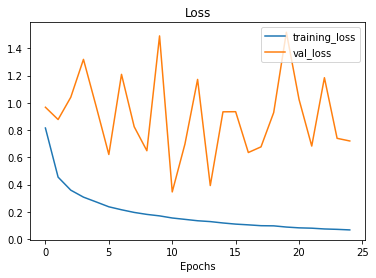

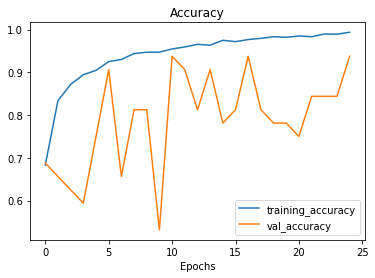

In [ ]:
plot_loss_curves(resnet_history)

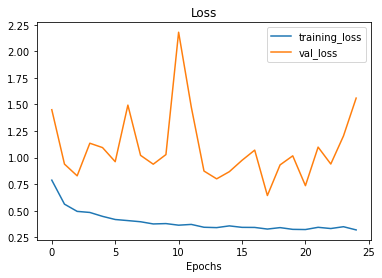

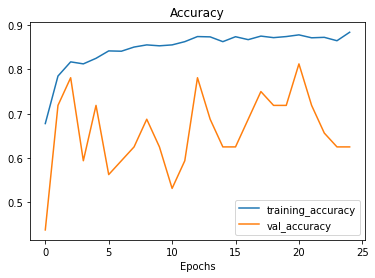

In [ ]:
plot_loss_curves(aug_resnet_history)

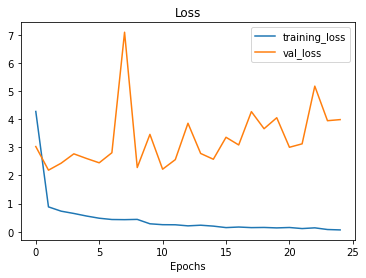

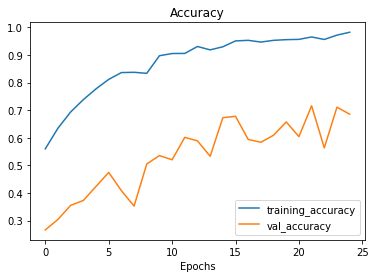

In [ ]:
plot_loss_curves(alexnet_history)

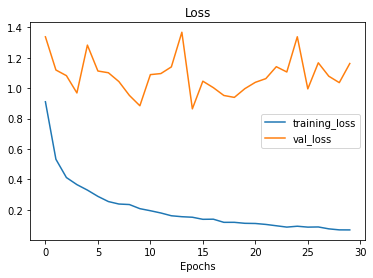

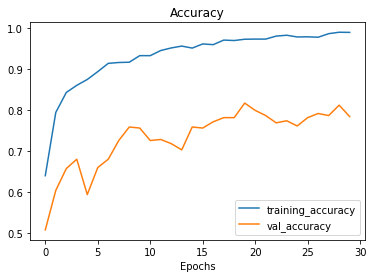

In [ ]:
plot_loss_curves(inceptionv3_history)

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import random
def load_prep(filename,img_shape=180):

    img=tf.io.read_file(filename)
    img=tf.image.decode_image(img,channels=3)
    img=tf.image.resize(img,size=[img_shape,img_shape])

    img=img/255.
    return img

def pred_and_plot(model, filename, class_names):
  import numpy as np
  img = load_prep(filename)
  pred = model.predict(tf.expand_dims(img, axis=0))
  result=pred.argmax()
  pred_class = class_names[result]

  plt.imshow(img)
  plt.title(f"Prediction: {pred_class}")
  plt.axis(False);

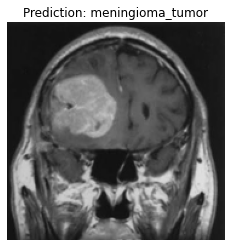

In [ ]:
pred_and_plot(resnet_model, "/content/image(15).jpg", class_names)